### Manage imports


In [1]:
import scipy
from scipy import signal
import torch
import skimage
import pywt
import os
import mne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from einops import reduce
import seaborn as sns
from scipy import io

from Electrodes import Electrodes

plt.rcParams.update({'figure.max_open_warning': 0})

### Read data from local

In [2]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

In [3]:
raw_file_names = os.listdir(RAW_DIR)
raw_file_names.sort()
all_subjects = [scipy.io.loadmat(f'{RAW_DIR}/{name}') for name in raw_file_names]

In [4]:
all_data = [subject['data'] for subject in all_subjects]
all_labels = [subject['labels'] for subject in all_subjects]
labels = np.stack(all_labels)
all_labels = reduce(labels,'s v c -> (s v) c','mean')
data = np.stack(all_data)
all_data = reduce(data,'s v c d -> (s v) c d','mean')

In [5]:
# Keep just EEG and remove baseline
all_data = all_data[:,:32,128*3:]

In [6]:
first_video = all_data[0]
first_video.shape

(32, 7680)

# First video for first participant

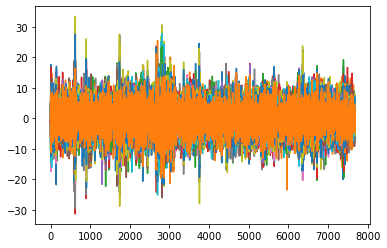

(32, 7680)

In [7]:
plt.plot(first_video.T)
plt.show()
first_video.shape

# First window (sample) taken from first_video

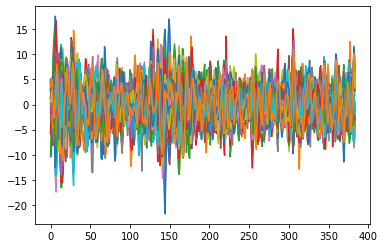

(32, 384)

In [33]:
window_size = 128*3 # 3 second window
first_window = first_video[:,:window_size]
plt.plot(first_window.T)
plt.show()
first_window.shape

# Extract Wavelet Energy (WE) feature from first_window

1. Make segments from window:
    - Overlap (boolean)
    - Segment size

In [34]:
overlap_segments = True
segment_size = 128*3

window_segments = skimage.util.view_as_windows(first_window, (32,segment_size), step=segment_size//2 if overlap_segments else segment_size ).squeeze()
window_segments.shape

(32, 384)

In [35]:
window_segments = window_segments if window_segments.shape[0] != 32 else np.expand_dims(window_segments, axis=0)

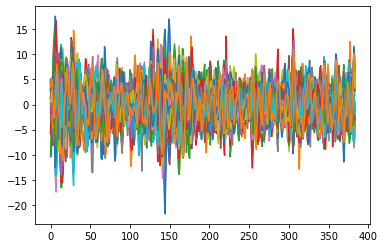

In [36]:
for s in window_segments:
    plt.plot(s.T)
    plt.show()

In [37]:
window_segments = window_segments.transpose(1,0,2)

In [38]:
def get_wavelet_energy(cD):
    cD = np.square(cD)
    return np.sum(cD, axis=-1)

## Decompose each segment into 5 frequency bands, discard the first and get wavelet energy for the rest

In [39]:
mother_wavelet = 'db4'
N = 5
cA, cD = pywt.dwt(window_segments, mother_wavelet)
features = []
for i in range(N-1):
    cA, cD = pywt.dwt(cA, mother_wavelet)
    features.append(get_wavelet_energy(cD))

In [40]:
features = torch.FloatTensor(features)
features.shape

torch.Size([4, 32, 1])

In [41]:
features

tensor([[[1739.3138],
         [1934.3878],
         [1934.9258],
         [1663.3292],
         [ 876.8284],
         [1092.5724],
         [ 930.2666],
         [2027.9159],
         [ 960.2089],
         [ 719.8305],
         [1417.5363],
         [1671.0642],
         [1579.7814],
         [1784.0128],
         [1433.1234],
         [1301.6078],
         [2190.5969],
         [1769.5101],
         [1485.3032],
         [1873.4634],
         [2442.9683],
         [1161.0940],
         [1077.3201],
         [1162.3125],
         [ 860.0700],
         [1365.9579],
         [1054.8347],
         [ 880.7297],
         [2024.9556],
         [1303.3640],
         [1837.0852],
         [1557.0986]],

        [[3125.6580],
         [3544.0359],
         [4005.7664],
         [3508.9597],
         [1854.5164],
         [1568.6113],
         [1900.9365],
         [2737.2478],
         [2838.2773],
         [1759.5613],
         [5023.2476],
         [4448.2686],
         [5689.5044],
        

### Z-Score normalization

In [42]:
# Normalization
m = features.mean(0, keepdim=True)
s = features.std(0, unbiased=False, keepdim=True)
features -= m
features /= s

In [43]:
features

tensor([[[ 0.1646],
         [ 0.1828],
         [-0.0148],
         [-0.0959],
         [ 0.0563],
         [ 0.2723],
         [ 0.0043],
         [ 0.4341],
         [-0.4100],
         [-0.1977],
         [-0.4308],
         [-0.2700],
         [-0.3204],
         [-0.1257],
         [-0.2616],
         [ 0.1621],
         [-0.0120],
         [ 0.4290],
         [-0.0204],
         [ 0.0647],
         [ 0.2536],
         [ 0.1146],
         [-0.0207],
         [ 1.1183],
         [ 0.3927],
         [-0.1306],
         [ 0.3488],
         [ 0.5703],
         [ 0.0650],
         [ 0.2904],
         [-0.1622],
         [-0.1533]],

        [[ 1.4371],
         [ 1.4667],
         [ 1.4861],
         [ 1.4437],
         [ 1.5623],
         [ 1.3313],
         [ 1.5014],
         [ 1.2985],
         [ 1.6199],
         [ 1.5431],
         [ 1.5620],
         [ 1.6083],
         [ 1.6585],
         [ 1.4997],
         [ 1.1717],
         [ 1.4309],
         [ 1.2472],
         [ 1.2576]

### Outputs are four feature matrices, one per frequency band. The shape of the feature vectors (shape[-1]) will vary depending on the number of segments

In [19]:
features.shape

torch.Size([4, 32, 39])

# Extract Power Spectral Density (PSD) from first_window

In [20]:
first_window.shape

(32, 7680)

In [21]:
freqs, psd = signal.welch(first_window,fs=128)

In [22]:
freqs.shape, psd.shape

((129,), (32, 129))

In [23]:
freqs

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
       55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
       60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. ])

### Power spectral density (PSD)

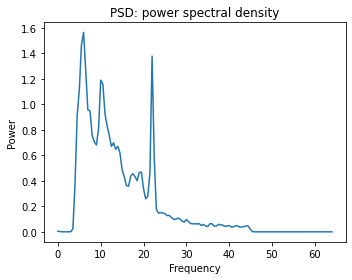

In [24]:
plt.figure(figsize=(5, 4))
plt.plot(freqs, psd[0])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

### Logarithmic power spectral density (LPSD)

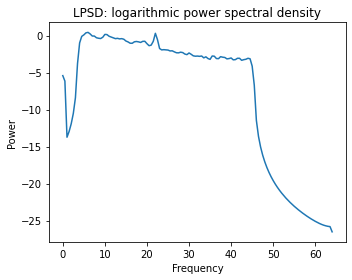

In [25]:
plt.figure(figsize=(5, 4))
plt.plot(freqs, np.log(psd[0]))
plt.title('LPSD: logarithmic power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

### Step 1) Split into frequency bands

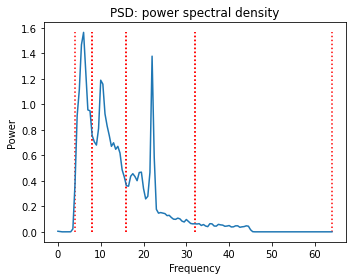

In [26]:
bands = [(4,8),(8,16),(16,32),(32,64)]
plt.figure(figsize=(5, 4))
plt.plot(freqs, psd[0])
for band_from,band_to in bands:
    plt.vlines(band_from,0,psd[0].max(),color='red',linestyles='dotted')
    plt.vlines(band_to,0,psd[0].max(),color='red',linestyles='dotted')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

### Step 2) Split each frequency band into s segments, get mean psd for every segment

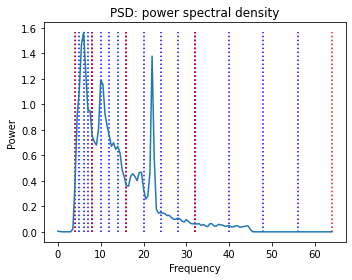

In [27]:
s = 4
bands = [(4,8),(8,16),(16,32),(32,64)]
plt.figure(figsize=(5, 4))
plt.plot(freqs, psd[0])
features = []
for band_from,band_to in bands:
    
    freq_mask = np.logical_and(freqs>=band_from,freqs<band_to)
    psd_band = psd[0,freq_mask]
    freqs_band = freqs[freq_mask]
    for l in np.split(freqs_band,s):
        plt.vlines(l[0],0,psd[0].max(),color='blue',linestyles='dotted')
    for l in np.split(psd_band,s):
        features.append(l.mean())
    
    plt.vlines(band_from,0,psd[0].max(),color='red',linestyles='dotted')
    plt.vlines(band_to,0,psd[0].max(),color='red',linestyles='dotted')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [28]:
features

[0.6450228101924946,
 1.2911172768951433,
 1.4158739142367613,
 0.9533471482405675,
 0.7388589811790517,
 1.0264864249681915,
 0.6934058690847877,
 0.5520090679602738,
 0.4226950091996996,
 0.453714116413792,
 0.12598424158125568,
 0.08452417086540799,
 0.05337920074027035,
 0.027863021876516902,
 5.046418356062129e-09,
 2.0185922593319737e-11]

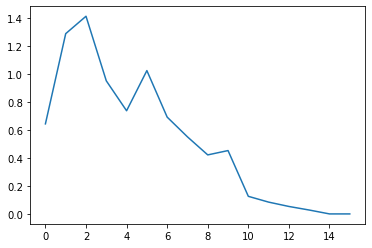

In [29]:
plt.plot(features)

In [30]:
features = torch.FloatTensor(features)
# Normalization
m = features.mean(0, keepdim=True)
s = features.std(0, unbiased=False, keepdim=True)
features -= m
features /= s

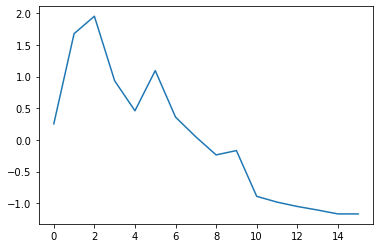

In [31]:
plt.plot(features)

In [32]:
features.shape

torch.Size([16])